# Quickstart: Building a Semantic Layer with Intugle

This notebook provides a quick introduction to this project. You'll learn how to use its key features to automatically build a semantic layer over your data.

**What is a Semantic Layer?**

A semantic layer is a business-friendly representation of your data. It hides the complexity of the underlying data sources and provides a unified view of your data using familiar business terms. This makes it easier for both business users and data teams to understand and query the data, accelerating data-driven insights.

**Who is this for?**

This tool is designed for both **data teams** and **business teams**. 

* **Data teams** can use it to automate data profiling, schema discovery, and documentation, significantly accelerating their workflow.
* **Business teams** can use it to gain a better understanding of their data and to perform self-service analytics without needing to write complex SQL queries.

**In this notebook, you will learn how to:**

1. **Profile your data:** Analyze your data sources to understand their structure, data types, and other characteristics.
2. **Business Glossary Generation:** Generate a business glossary for each column, with support for industry-specific domains.
2. **Automatically predict links:** Use a Large Language Model (LLM) to automatically discover relationships (foreign keys) between tables.
3. **Generate a semantic layer:** Create YAML files file that defines your semantic layer.
4. **Generate SQL queries:** Use the semantic layer to generate SQL queries and retrieve data.

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables.

You can configure the LLM by setting the following environment variables:

* `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`). The format follows langchain's format for initializing chat models. Checkout how to specify your model [here](https://python.langchain.com/docs/integrations/chat/) 
* `OPENAI_API_KEY`: Your API key for the LLM provider.

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```

Alternatively, you can set them in the notebook like this:

In [ ]:
import os

os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"  # Replace with your actual key


> Currently the langchain packages for OpenAI, Anthropic and Gemini is installed by default. For additional models, make sure you have the integration packages installed. E.g. you should have langchain-deepseek installed to use a DeepSeek model. You can get these packages here: [LangChain Chat Models](https://python.langchain.com/docs/integrations/chat/)

## 2. Data Profiling and Glossary Generation

The first step in building a semantic layer is to profile your data. This involves analyzing your data sources to understand their structure, data types, and other characteristics. This tool provides a pipeline for this purpose. It can also generate business glossary for your data.


In [10]:
from intugle import DataSet

In [11]:
allergies_data = {
    "path": "https://raw.githubusercontent.com/Intugle/data-tools/refs/heads/main/sample_data/healthcare/allergies.csv",
    "type": "csv"
}
# Create a DataSet object and run the profiling pipeline
dataset_allergies = DataSet(allergies_data, "allergies")
dataset_allergies.run(domain="Healthcare")

# Or you can run each step manually:
# dataset_allergies.profile().identify_datatypes().identify_keys().generate_glossary(domain="Healthcare")

allergies loaded


/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[!] Empty column encountered for allergies ==> stop ...
100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


,column_name,business_name,table_name,null_count,count,distinct_count,uniqueness,completeness,sample_data,dtype_sample,ts,datatype_l1,datatype_l2,business_glossary,business_tags
0,start,start,allergies,0,794,179,0.225441,1.0,"[2006-08-07, 2001-04-09, 2011-02-04, 1958-10-2...","[2009-02-19, 1991-11-18, 1976-04-09, 2013-07-2...",0.036076,date & time,L2OutputTypes.dimension,Indicates the date and time when an allergy re...,"[Allergy Onset Date, Patient Medical History, ..."
1,stop,stop,allergies,794,794,0,0.000000,0.0,[],[],0.006042,others,L2OutputTypes.unknown,Indicates the conclusion or cessation of a spe...,"[AllergyEndDate, PatientCareTimeline, Clinical..."
2,patient,patient,allergies,0,794,179,0.225441,1.0,"[65c925be-8fda-2bf1-6702-4fcbcb725628, 246fb36...","[9ef4db86-c427-ddfe-a607-737f08ffb0c1, 4ba1518...",0.006320,alphanumeric,L2OutputTypes.dimension,Identifies individuals associated with recorde...,"[Patient Identifier, Healthcare Entity, Allerg..."
3,encounter,encounter,allergies,0,794,179,0.225441,1.0,"[a7d784e9-8503-e26f-b98f-e34ca8a4bad0, 704f899...","[04effe72-a3c5-e479-b6d3-5f6fb7ac8601, be166b8...",0.004151,alphanumeric,L2OutputTypes.dimension,A unique identifier associated with a specific...,"[Patient Encounter, Clinical Visit Identifier,..."
4,code,code,allergies,0,794,21,0.026448,1.0,"[264287008, 25037, 412071004, 288328004, 76295...","[3718001, 256355007, 10831, 111088007, 1191, 4...",0.004685,integer,L2OutputTypes.dimension,Identifies specific allergens or allergy-relat...,"[Allergy Classification, Clinical Code, Health..."


The `run()` method performs a series of analysis steps, including:

* **Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
* **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
* **Key Identification:** Identifies potential primary keys.
* **Glossary Generation:** Generates a business glossary for each column using an LLM.

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").


In [14]:
dataset_allergies.result_to_pandas()[["business_glossary"]]

,business_glossary
0,Indicates the date and time when an allergy re...
1,Indicates the conclusion or cessation of a spe...
2,Identifies individuals associated with recorde...
3,A unique identifier associated with a specific...
4,Identifies specific allergens or allergy-relat...
5,Identifies the source or classification framew...
6,Provides the name or type of allergen associat...
7,Categorizes the nature of a condition related ...
8,Classifies the type of allergen relevant to an...
9,Describes the specific physical or physiologic...


In [3]:
dataset_allergies.to_df()

,start,stop,patient,encounter,code,system,description,type,category,reaction1,description1,severity1,reaction2,description2,severity2
0,2020-02-17,None,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,111088007,Unknown,Latex (substance),allergy,environment,247472004,Wheal (finding),MILD,<NA>,None,None
1,2020-02-17,None,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,84489001,Unknown,Mold (organism),allergy,environment,76067001,Sneezing,MILD,<NA>,None,None
2,2020-02-17,None,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,260147004,Unknown,House dust mite (organism),allergy,environment,<NA>,None,None,<NA>,None,None
3,2020-02-17,None,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,264287008,Unknown,Animal dander (substance),allergy,environment,878820003,Rhinoconjunctivitis (disorder),MODERATE,271807003,Eruption of skin (disorder),MILD
4,2020-02-17,None,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,01efcc52-15d6-51e9-faa2-bee069fcbe44,256277009,Unknown,Grass pollen (substance),allergy,environment,<NA>,None,None,<NA>,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,1987-05-20,None,27cb1c2f-4ec0-6e24-d080-e46178f712d5,04d64fc5-6137-3d7a-06b6-dd6dc2d6a7c1,442571000124108,Unknown,Tree nut (substance),allergy,food,39579001,Anaphylaxis (disorder),SEVERE,49727002,Cough (finding),MODERATE
790,2001-04-09,None,0cf08145-a634-329f-54d3-9cbd04ba18cc,ef2f78b9-750e-607b-f3f4-3de39ee2eeec,1191,Unknown,Aspirin,allergy,medication,247472004,Wheal (finding),MODERATE,<NA>,None,None
791,2001-04-09,None,0cf08145-a634-329f-54d3-9cbd04ba18cc,ef2f78b9-750e-607b-f3f4-3de39ee2eeec,102263004,Unknown,Eggs (edible) (substance),allergy,food,247472004,Wheal (finding),MODERATE,<NA>,None,None
792,1980-08-15,None,9c532b25-cd38-f13a-f2de-2f5538326ed6,b3afbc77-ec8c-1cf8-05fe-740c91fa1d0f,1191,Unknown,Aspirin,allergy,medication,<NA>,None,None,<NA>,None,None


In [4]:
from intugle.core.settings import settings

settings.PROJECT_BASE

'/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/notebooks/models'

## 3. Automated Link Prediction

Now that we've profiled our data, let's discover the relationships between tables. This tool uses an LLM to predict links (foreign keys) between tables.

First, we'll load a few more tables from the sample dataset.

In [ ]:
table_names = ["patients", "claims", "careplans", "claims_transactions", "medications"]
datasets = [dataset_allergies]


def generate_config(table_name: str) -> str:
    """Append the base URL to the table name."""
    return {
        "path": f"https://raw.githubusercontent.com/Intugle/data-tools/refs/heads/main/sample_data/healthcare/{table_name}.csv",
        "type": "csv"
    }


for table_name in table_names:
    config = generate_config(table_name)
    dataset = DataSet({**config}, table_name)
    dataset.profile_table()
    dataset.run(domain="Healthcare")
    datasets.append(dataset)

/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 44%|████▍     | 11/25 [00:05<00:06,  2.06it/s][!] Error while llm response parsing: Got invalid JSON object. Error: Expecting ',' delimiter: line 2 column 27 (char 28)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
[*] patients:   0%|          | 0/1 [00:00<?, ?it/s]/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/src/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

Now, let's run the link prediction pipeline.

In [6]:
from intugle import LinkPredictor

# Initialize the predictor
predictor = LinkPredictor(datasets)

# Run the prediction
results = predictor.predict(save=True)
results.links

Dataset 'allergies' is missing key identification. Running prerequisite analysis...


/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[!] Empty column encountered for allergies ==> stop ...
  0%|          | 0/15 [00:00<?, ?it/s][!] Error while llm response parsing: Got invalid JSON object. Error: Expecting ',' delimiter: line 2 column 27 (char 28)
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE 
100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Dataset 'patients' already processed. Skipping analysis.
Dataset 'claims' already processed. Skipping analysis.
Dataset 'careplans' already processed. Skipping analysis.
Dataset 'claims_transactions' already processed. Skipping analysis.
Dataset 'medications' is missing key identification. Running prerequisite analysis...


/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


LinkPredictor initialized with datasets: ['allergies', 'patients', 'claims', 'careplans', 'claims_transactions', 'medications']

--- Comparing 'allergies' <=> 'patients' ---


[*] allergies <==> patients Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Found 1 potential link(s).

--- Comparing 'allergies' <=> 'claims' ---


[*] allergies <==> claims Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'careplans' ---


[*] allergies <==> careplans Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'claims_transactions' ---


[*] allergies <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


No links found for this pair.

--- Comparing 'allergies' <=> 'medications' ---


[*] allergies <==> medications Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]


No links found for this pair.

--- Comparing 'patients' <=> 'claims' ---


[*] patients <==> claims Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


Found 1 potential link(s).

--- Comparing 'patients' <=> 'careplans' ---


[*] patients <==> careplans Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 potential link(s).

--- Comparing 'patients' <=> 'claims_transactions' ---


[*] patients <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Found 1 potential link(s).

--- Comparing 'patients' <=> 'medications' ---


[*] patients <==> medications Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'careplans' ---


[*] claims <==> careplans Runs:1: 100%|██████████| 1/1 [00:18<00:00, 18.78s/it]


No links found for this pair.

--- Comparing 'claims' <=> 'claims_transactions' ---


[*] claims <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:16<00:00, 16.40s/it]


Found 1 potential link(s).

--- Comparing 'claims' <=> 'medications' ---


[*] claims <==> medications Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.06s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'claims_transactions' ---


[*] careplans <==> claims_transactions Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


No links found for this pair.

--- Comparing 'careplans' <=> 'medications' ---


[*] careplans <==> medications Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Found 1 potential link(s).

--- Comparing 'claims_transactions' <=> 'medications' ---


[*] claims_transactions <==> medications Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]

No links found for this pair.


[PredictedLink(from_dataset='allergies', from_column='patient', to_dataset='patients', to_column='id'),
 PredictedLink(from_dataset='patients', from_column='id', to_dataset='claims', to_column='patientid'),
 PredictedLink(from_dataset='patients', from_column='id', to_dataset='careplans', to_column='patient'),
 PredictedLink(from_dataset='patients', from_column='id', to_dataset='claims_transactions', to_column='patientid'),
 PredictedLink(from_dataset='patients', from_column='id', to_dataset='medications', to_column='patient'),
 PredictedLink(from_dataset='claims', from_column='id', to_dataset='claims_transactions', to_column='claimid'),
 PredictedLink(from_dataset='careplans', from_column='encounter', to_dataset='medications', to_column='encounter')]

The `results` object contains the predicted links between the tables. You can also visualize the relationships as a graph.


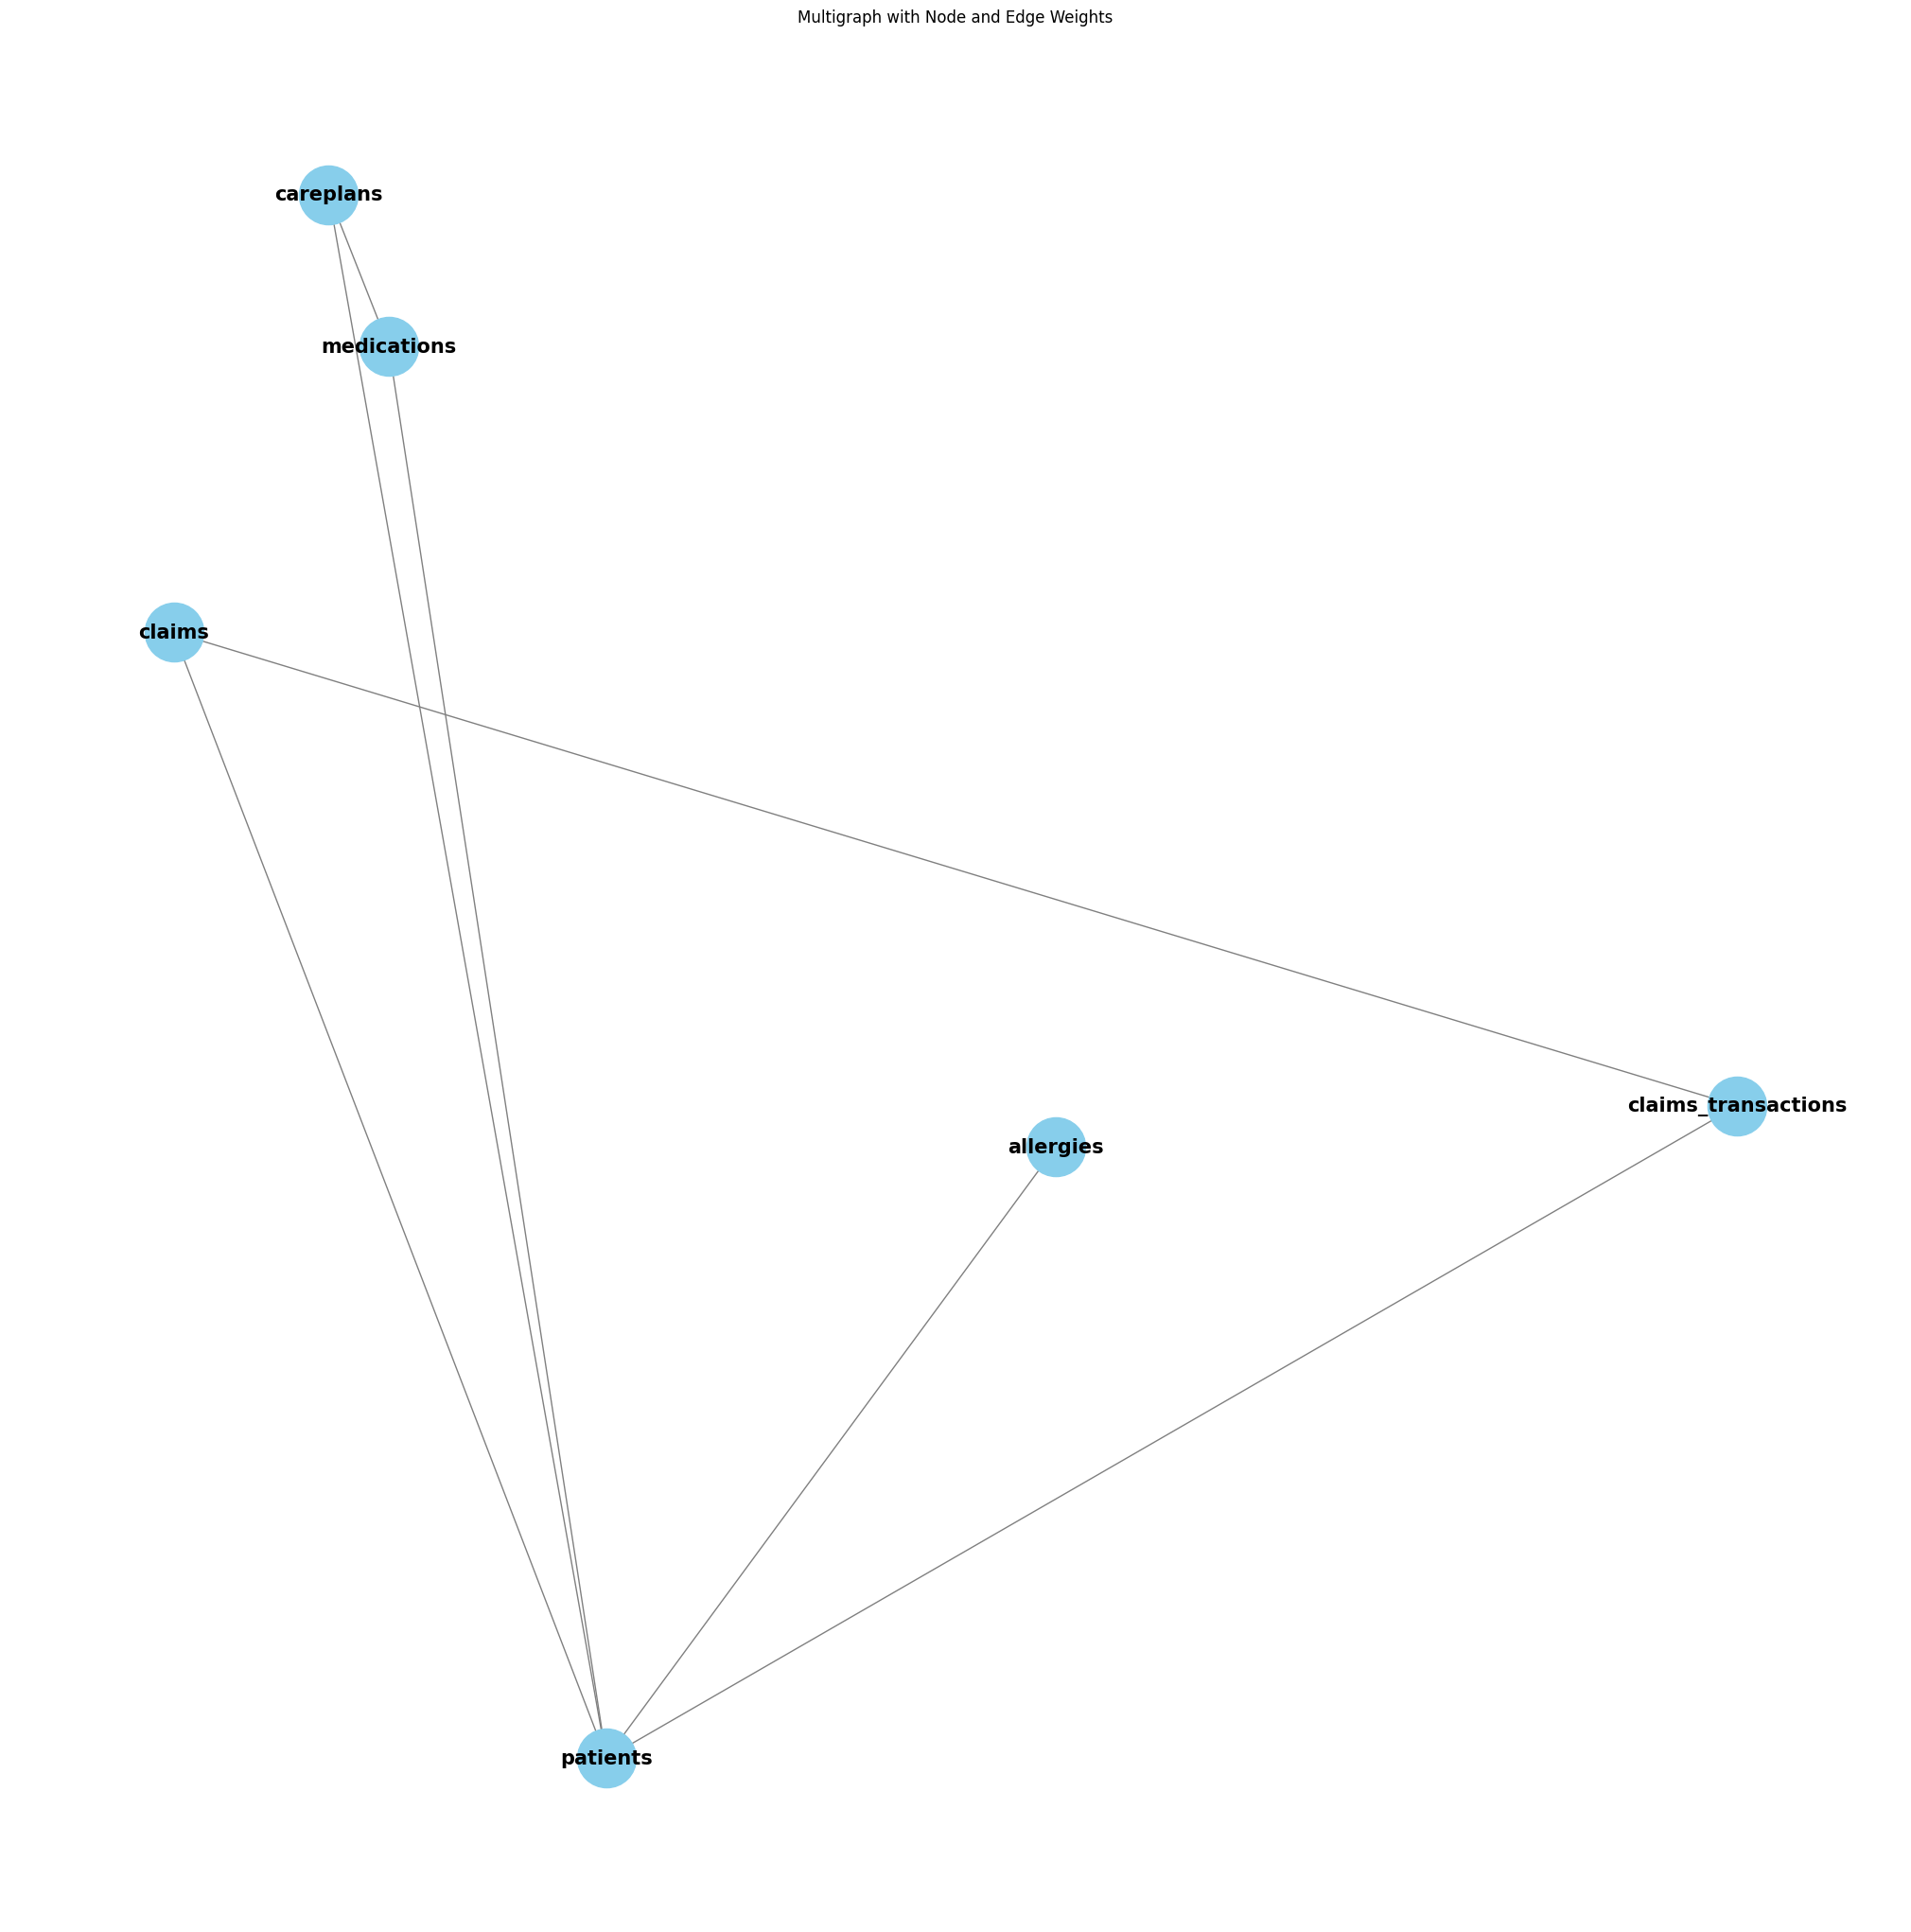

In [11]:
results.show_graph()


## 4. The Semantic Layer

The profiling and link prediction results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory. You can configure this path by setting the `PROJECT_BASE` environment variable. They can also be saved manually as shown below:

In [8]:
for ds in datasets:
    ds.save_yaml()

results.save_yaml("relationships.yml")

Now, we can load the YAML files and create a manifest.

## 5. SQL Generation

Once you have a semantic layer, you can use the `SqlGenerator` to generate SQL queries. This allows you to query the data using business-friendly terms, without having to write complex SQL.

Let's create an ETL model to define the query we want to generate.

In [1]:

etl = {
    "name": "patient_names",
    "fields": [
        {"id": "patients.first", "name": "first_name"},
        {"id": "patients.last", "name": "last_name"},
        {"id": "allergies.start", "name": "start_date"},
    ],
    "filter": {
        "selections": [{"id": "claims.departmentid", "values": ["3", "20"]}],
    },
}

Now, let's use the `SqlGenerator` to generate the SQL query.

In [2]:
from intugle.sql_generator import SqlGenerator


/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/juhel-phanju/Documents/intugle/projects/data-tools/data-tools/.venv/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "Source" shadows an attribute in parent "BaseResource"
  warnings.warn(


In [3]:

# Create a SqlGenerator
sql_generator = SqlGenerator()

# Generate the query
test_etl = sql_generator.generate_product(etl)

# Print the query
test_etl.data

careplans loaded
claims loaded
claims_transactions loaded
patients loaded
medications loaded
allergies loaded
patient_names
patient_names loaded


{'path': "SELECT patients.first as first_name, patients.last as last_name, allergies.start as start_date FROM claims LEFT JOIN patients ON patients.id = claims.patientid LEFT JOIN allergies ON allergies.patient = patients.id WHERE (claims.departmentid IN ('3', '20'))",
 'type': 'query'}

In [4]:
test_etl.to_df()

,first_name,last_name,start_date
0,Miki234,Kozey370,1981-05-17
1,Maddie576,Gutmann970,1960-01-05
2,Esther279,Runolfsson901,1960-05-21
3,Bonita405,Bernier607,2011-03-26
4,Magdalene960,Orn563,1995-07-11
...,...,...,...
1543,Zelda766,Ernser583,NaT
1544,Zelda766,Ernser583,NaT
1545,Zelda766,Ernser583,NaT
1546,Zelda766,Ernser583,NaT


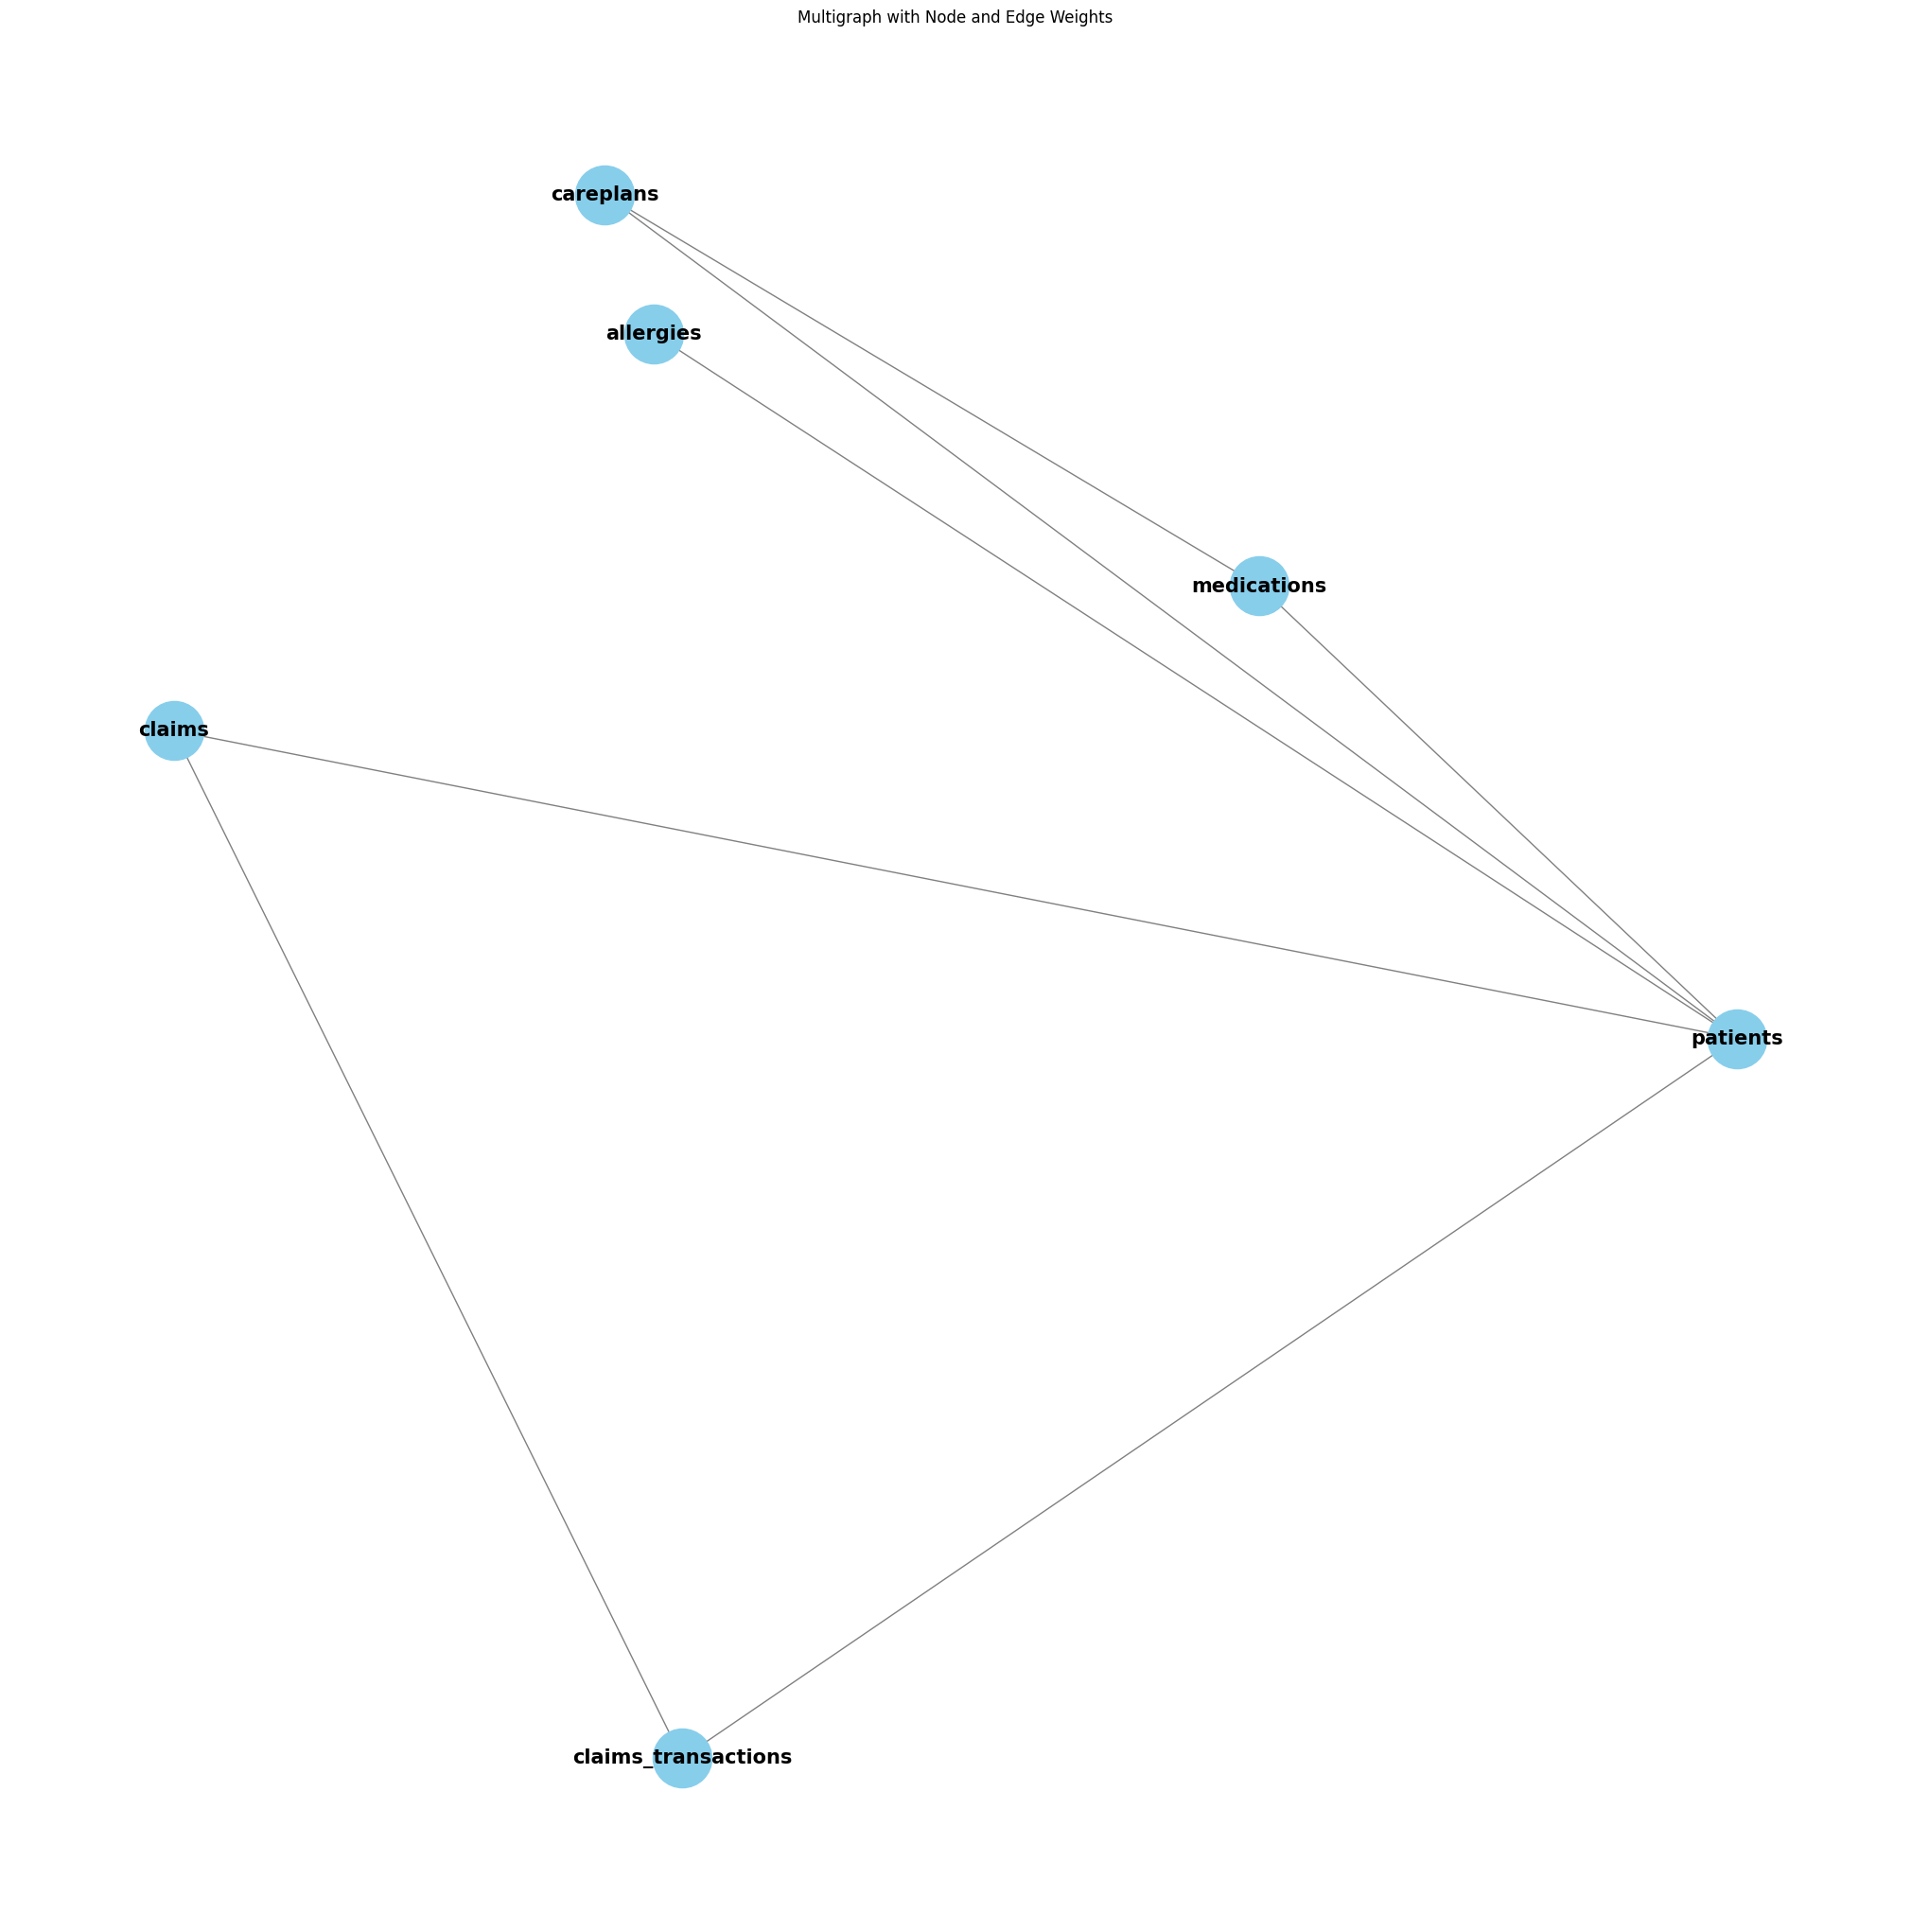

In [8]:
sql_generator.plot_sources_graph()

## 6. MCP Server: Interacting with Your Semantic Layer

Now that you have a semantic layer, you can serve it as a MCP server to interact with it using natural language. The MCP server exposes your semantic layer as a set of tools that can be used by any MCP client.

### Starting the MCP Server

To start the MCP server, run the following command in your terminal:

```bash
intugle-mcp
```

This will start a server on `localhost:8000`.

### Connecting to the MCP Server

Once the server is running, you can connect to it from any MCP client. The endpoint for the MCP server is:

`http://localhost:8000/semantic_layer/mcp`

You can use a variety of MCP clients to connect to the server, such as Claude Desktop, Gemini CLI etc.

### Use Cases

Once connected, you can interact with your semantic layer using natural language. Here are some exciting applications:

*   **Generate SQL Queries:** Ask questions in natural language and have the MCP server generate the corresponding SQL query.
*   **Data Discovery:** Ask questions about the tables and columns in your semantic layer to better understand your data.

> To execute the generated SQL queries, you can also connect your database instance as a MCP tool to your client.

## Conclusion

You've learned how to:

* Configure your LLM provider.
* Profile your data to understand its characteristics.
* Use an LLM to automatically predict links between tables.
* Generate a semantic layer.
* Use the semantic layer to generate SQL queries.
* Interact with your semantic layer using the MCP server.

This is just a starting point. This project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.
